### Assignment 1

This notebook uses the notMNIST dataset to be used with python experiments. This dataset is designed to look like the classic MNIST dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://yaroslavvb.com/upload/notMNIST/'
last_percent_reported = None
data_root = '.'  # Change me to store data elsewhere


def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 5% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()

        last_percent_reported = percent


def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    dest_filename = os.path.join(data_root, filename)
    
    if force or not os.path.exists(dest_filename):
        print(('Attempting to download:', filename))
        filename, _ = urlretrieve(url + filename,
                                  dest_filename,
                                  reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(dest_filename)
    
    if statinfo.st_size == expected_bytes:
        print(('Found and verified', dest_filename))
    else:
        raise Exception('Failed to verify ' + dest_filename +
                        '. Can you get to it with a browser?')
    
    return dest_filename


train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

('Found and verified', '.\\notMNIST_large.tar.gz')
('Found and verified', '.\\notMNIST_small.tar.gz')


In [6]:
num_classes = 10
np.random.seed(133)


def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print(('%s already present - Skipping extraction of %s.' %
               (root, filename)))
    else:
        print(('Extracting data for %s. This may take a while. Please wait.' %
               root))
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))
    ]
    
    if len(data_folders) != num_classes:
        raise Exception(
            'Expected %d folders, one per class. Found %d instead.' %
            (num_classes, len(data_folders)))
    
    print(data_folders)
    return data_folders


train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

.\notMNIST_large already present - Skipping extraction of .\notMNIST_large.tar.gz.
['.\\notMNIST_large\\A', '.\\notMNIST_large\\B', '.\\notMNIST_large\\C', '.\\notMNIST_large\\D', '.\\notMNIST_large\\E', '.\\notMNIST_large\\F', '.\\notMNIST_large\\G', '.\\notMNIST_large\\H', '.\\notMNIST_large\\I', '.\\notMNIST_large\\J']
.\notMNIST_small already present - Skipping extraction of .\notMNIST_small.tar.gz.
['.\\notMNIST_small\\A', '.\\notMNIST_small\\B', '.\\notMNIST_small\\C', '.\\notMNIST_small\\D', '.\\notMNIST_small\\E', '.\\notMNIST_small\\F', '.\\notMNIST_small\\G', '.\\notMNIST_small\\H', '.\\notMNIST_small\\I', '.\\notMNIST_small\\J']


### check data

Train set A


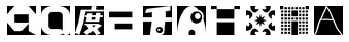

Train set B


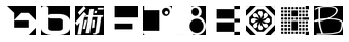

Train set C


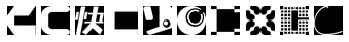

Train set D


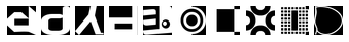

Train set E


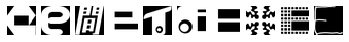

Train set F


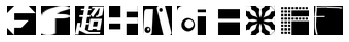

Train set G


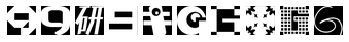

Train set H


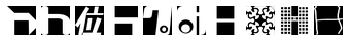

Train set I


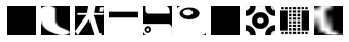

Train set J


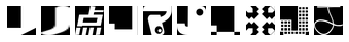

In [9]:
from PIL import Image
import glob


chars = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

train_list = {}
test_list = {}
for char in chars:
    train_list[char] = glob.glob('notMNIST_large/' + char + '/*.png')
    test_list[char] = glob.glob('notMNIST_small/' + char + '/*.png')


def display_samples(path_list, n_samples=10):
    
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1).set_yticklabels([])
        plt.imshow(Image.open(path_list[i]))
        plt.gray()
        plt.axis('off')
    
    plt.show()
    plt.close()
    
print('Train set A')
display_samples(train_list['A'])
print('Train set B')
display_samples(train_list['B'])
print('Train set C')
display_samples(train_list['C'])
print('Train set D')
display_samples(train_list['D'])
print('Train set E')
display_samples(train_list['E'])
print('Train set F')
display_samples(train_list['F'])
print('Train set G')
display_samples(train_list['G'])
print('Train set H')
display_samples(train_list['H'])
print('Train set I')
display_samples(train_list['I'])
print('Train set J')
display_samples(train_list['J'])

In [11]:
for i in range(3):
    display(Image.open(test_list['A'][i]))

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.

In [7]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.


def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (imageio.imread(image_file).astype(float) -
                          pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' %
                                str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except (IOError, ValueError) as e:
            print(('Could not read:', image_file, ':', e,
                   '- it\'s ok, skipping.'))

    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                        (num_images, min_num_images))

    print(('Full dataset tensor:', dataset.shape))
    print(('Mean:', np.mean(dataset)))
    print(('Standard deviation:', np.std(dataset)))
    return dataset


def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print(('%s already present - Skipping pickling.' % set_filename))
        else:
            print(('Pickling %s.' % set_filename))
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print(('Unable to save data to', set_filename, ':', e))

    return dataset_names


train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling .\notMNIST_large\A.pickle.
.\notMNIST_large\A
('Could not read:', '.\\notMNIST_large\\A\\RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png', ':', ValueError("Could not find a format to read the specified file in mode 'i'",), "- it's ok, skipping.")
('Could not read:', '.\\notMNIST_large\\A\\SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png', ':', ValueError("Could not find a format to read the specified file in mode 'i'",), "- it's ok, skipping.")
('Could not read:', '.\\notMNIST_large\\A\\Um9tYW5hIEJvbGQucGZi.png', ':', ValueError("Could not find a format to read the specified file in mode 'i'",), "- it's ok, skipping.")
('Full dataset tensor:', (52909, 28, 28))
('Mean:', -0.12825024)
('Standard deviation:', 0.44312063)
Pickling .\notMNIST_large\B.pickle.
.\notMNIST_large\B
('Could not read:', '.\\notMNIST_large\\B\\TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png', ':', ValueError("Could not find a format to read the specified file in mode 'i'",), "- it's ok, skipping.")
('Full dataset tensor:', (529

### Let's verify that the data still looks good.

Train set A


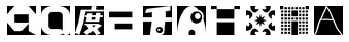

Train set B


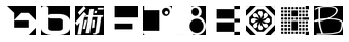

Train set C


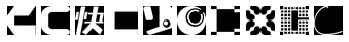

Train set D


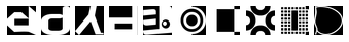

Train set E


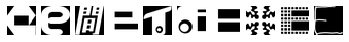

In [12]:
train_dataset = {}
test_dataset = {}
for char in chars:
    
    try:
        train_dataset[char] = pickle.load(
            open('./notMNIST_large/' + char + '.pickle', 'rb'))
    except IOError:
        print('file does not exist: ' + './notMNIST_large/' + char + '.pickle')
    
    try:
        test_dataset[char] = pickle.load(
            open('./notMNIST_small/' + char + '.pickle', 'rb'))
    except IOError:
        print('file does not exist: ' + './notMNIST_large/' + char + '.pickle')
        

def display_dataset_samples(samples, n_samples=10):
    for i in range(n_samples):
        plt.subplot(1, n_samples, i +1)
        plt.imshow(samples[i])  # 已是处理好的图片数据
        plt.axis('off')
    plt.show()
    plt.close()
            

print('Train set A')
display_dataset_samples(train_dataset['A'])
print('Train set B')
display_dataset_samples(train_dataset['B'])
print('Train set C')
display_dataset_samples(train_dataset['C'])
print('Train set D')
display_dataset_samples(train_dataset['D'])
print('Train set E')
display_dataset_samples(train_dataset['E'])

Test set A


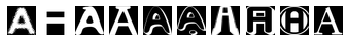

Test set B


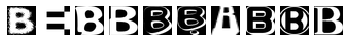

Test set C


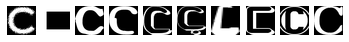

Test set D


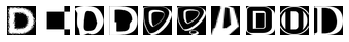

Test set E


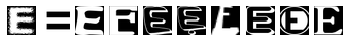

In [13]:
print('Test set A')
display_dataset_samples(test_dataset['A'])
print('Test set B')
display_dataset_samples(test_dataset['B'])
print('Test set C')
display_dataset_samples(test_dataset['C'])
print('Test set D')
display_dataset_samples(test_dataset['D'])
print('Test set E')
display_dataset_samples(test_dataset['E'])

In [14]:
# we expect the data to be balanced across classes
for char in chars:
    print('number of train samples for ' + char + ': ' + str(train_dataset[char].shape[0]))
    
for char in chars:
    print('number of test samples for ' + char + ': ' + str(test_dataset[char].shape[0]))

number of train samples for A: 52909
number of train samples for B: 52911
number of train samples for C: 52912
number of train samples for D: 52911
number of train samples for E: 52912
number of train samples for F: 52912
number of train samples for G: 52912
number of train samples for H: 52912
number of train samples for I: 52912
number of train samples for J: 52911
number of test samples for A: 1872
number of test samples for B: 1873
number of test samples for C: 1873
number of test samples for D: 1873
number of test samples for E: 1873
number of test samples for F: 1872
number of test samples for G: 1872
number of test samples for H: 1872
number of test samples for I: 1872
number of test samples for J: 1872


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [15]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels


def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes

    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class + tsize_per_class
    for label, pickle_file in enumerate(pickle_files):
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class

                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise

    return valid_dataset, valid_labels, train_dataset, train_labels


train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
    train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [16]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels


train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

### Convince yourself that the data is still good after shuffling!

Train set


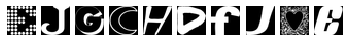

In [17]:
print('Train set')
display_dataset_samples(train_dataset)

Validation set


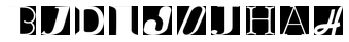

In [18]:
print('Validation set')
display_dataset_samples(valid_dataset)

Test set


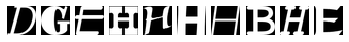

In [19]:
print('Test set')
display_dataset_samples(test_dataset)

Finally, let's save the data for later reuse:

In [20]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [21]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it. Measure how much overlap there is between training, validation and test samples.

Optional questions:

- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.


### hash检测训练测试集的重复

In [23]:
hashlib.algorithms_available

{'DSA',
 'DSA-SHA',
 'MD4',
 'MD5',
 'RIPEMD160',
 'SHA',
 'SHA1',
 'SHA224',
 'SHA256',
 'SHA384',
 'SHA512',
 'blake2b',
 'blake2s',
 'dsaEncryption',
 'dsaWithSHA',
 'ecdsa-with-SHA1',
 'md4',
 'md5',
 'ripemd160',
 'sha',
 'sha1',
 'sha224',
 'sha256',
 'sha384',
 'sha3_224',
 'sha3_256',
 'sha3_384',
 'sha3_512',
 'sha512',
 'shake_128',
 'shake_256',
 'whirlpool'}

In [24]:
import hashlib

full_dataset_name = './notMNIST.pickle'
try:
    dataset = pickle.load(open(full_dataset_name, 'rb'))
except IOError:
    print("file does not exist: " + full_dataset_name)
    
    
def count_overlaps(test_dataset, train_dataset):
    """return the number of overlapping samples and mapping"""
    n_overlaps = 0
    test_map = np.empty((test_dataset.shape[0]), dtype=bool)
    test_map.fill(True)
    
    hashset_train = [hashlib.sha1(sample).hexdigest() for sample in train_dataset]
    hashset_test = [hashlib.sha1(sample).hexdigest() for sample in test_dataset]
    
    for i in range(len(hashset_test)):
        if hashset_test[i] in hashset_train:
            n_overlaps = n_overlaps + 1
            test_map[i] = False
    
    return n_overlaps, test_map
    
n_train_test_overlaps, test_map = count_overlaps(dataset['test_dataset'], dataset['train_dataset'])
n_train_valid_overlaps, valid_map = count_overlaps(dataset['valid_dataset'], dataset['train_dataset'])

print('number of dublicates between train and test datasets: ' + str(n_train_test_overlaps))
print('number of dublicates between train and valid datasets: ' + str(n_train_valid_overlaps))

number of dublicates between train and test datasets: 1324
number of dublicates between train and valid datasets: 1067


In [26]:
# 或者imagehash，使用hamming distance计算相似图像，可以进一步提高检测结果
# 两个等长字符串之间的汉明距离是两个字符串对应位置的不同字符的个数
import imagehash


def dhash_fromarray(image_array, denormalize=True):
    """Difference Hash computation ---- dhash"""
    def denormalize_image(image_array, pixel_depth=255.0):
        return (image_array * pixel_depth) + pixel_depth / 2
    
    # 重回0~255
    if denormalize:
        image_array = denormalize_image(image_array)
        
    return (imagehash.dhash(Image.fromarray(image_array)))


def count_near_dublicates(test_dataset, train_dataset):
    """return the number of nearly dublicated samples and indices"""
    n_overlaps = 0
    test_map = np.empty((test_dataset.shape[0]), dtype=bool)
    test_map.fill(True)
    
    dhashed_test = [str(dhash_fromarray(sample)) for sample in test_dataset]
    dhashed_train = [str(dhash_fromarray(sample)) for sample in train_dataset]
   
    for i in range(len(dhashed_test)):
        if dhashed_test[i] in dhashed_train:
            n_overlaps = n_overlaps + 1
            test_map[i] = False
    
    return n_overlaps, test_map


n_train_test_nearly, test_map_near = count_near_dublicates(
    dataset['test_dataset'], dataset['train_dataset'])
n_train_valid_nearly, valid_map_near = count_near_dublicates(
    dataset['valid_dataset'], dataset['train_dataset'])

print('number of nearly dublicates between train and test datasets: ' +
      str(n_train_test_nearly))
print('number of nearly dublicates between train and valid datasets: ' +
      str(n_train_valid_nearly))

number of nearly dublicates between train and test datasets: 3640
number of nearly dublicates between train and valid datasets: 3060


In [27]:
# 清洗数据
dataset_sanit = {}

dataset_sanit['train_dataset'] = dataset['train_dataset']
dataset_sanit['test_dataset'] = dataset['test_dataset'][test_map, :, :]
dataset_sanit['valid_dataset'] = dataset['valid_dataset'][valid_map, :, :]

dataset_sanit['train_labels'] = dataset['train_labels']
dataset_sanit['test_labels'] = dataset['test_labels'][test_map]
dataset_sanit['valid_labels'] = dataset['valid_labels'][valid_map]

print(dataset['test_dataset'].shape[0] -
      dataset_sanit['test_dataset'].shape[0])
print(dataset['valid_dataset'].shape[0] -
      dataset_sanit['valid_dataset'].shape[0])

try:
    f = open('notMNIST_sanitized.pickle', 'wb')
    pickle.dump(dataset_sanit, f, pickle.HIGHEST_PROTOCOL)
    f.close()
    print('Successfullly pickled.')
except Exception as e:
    print('Unable to save data to ./notMNIST_sanitized.pickle', ':', e)
    raise

1324
1067
Successfullly pickled.


Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

### Logistic Regression

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
# load dataset
if not 'dataset' in globals():
    try:
        dataset = pickle.load(open('notMNIST.pickle', 'rb'))
    except IOError:
        print('file does not exist: notMNIST.pickle')

train = dataset['train_dataset']
test = dataset['test_dataset']
valid = dataset['valid_dataset']

train_labels = dataset['train_labels']
test_labels = dataset['test_labels']
valid_labels = dataset['valid_labels']

In [4]:
def train_lr(train_x, train_y, valid_x, valid_y, test_x, test_y, c_reg=1.0):
    """
    Train with logistic regression and return the score
    """    
    train_x = np.array([x.flatten() for x in train_x])
    valid_x = np.array([x.flatten() for x in valid_x])
    test_x = np.array([x.flatten() for x in test_x])
    
    classifier = LogisticRegression(C=c_reg)
    classifier.fit(train_x, train_y)
    
    score_train = classifier.score(train_x, train_y)
    score_valid = classifier.score(valid_x, valid_y)
    score_test = classifier.score(test_x, test_y)
    
    return (score_train, score_valid, score_test)

In [5]:
# 各个训练集有重叠的数据集
for n_samples in [50, 100, 1000, 5000]:
    scores = train_lr(train[:n_samples],
                      train_labels[:n_samples],
                      valid,
                      valid_labels,
                      test,
                      test_labels,
                      c_reg=0.1)
    print('train, valid and test scores for ' + str(n_samples) +
          ' training samples: %.3f, %.3f, %.3f' % scores)

train, valid and test scores for 50 training samples: 1.000, 0.456, 0.503
train, valid and test scores for 100 training samples: 0.990, 0.638, 0.703
train, valid and test scores for 1000 training samples: 0.937, 0.787, 0.855
train, valid and test scores for 5000 training samples: 0.887, 0.802, 0.873


In [6]:
# 清洗后的数据集
if not 'dataset_sanit' in globals():
    try:
        dataset_sanit = pickle.load(open('notMNIST_sanitized.pickle', 'rb'))
    except IOError:
        print('file does not exist: notMNIST_sanitized.pickle')

train = dataset_sanit['train_dataset']
test = dataset_sanit['test_dataset']
valid = dataset_sanit['valid_dataset']

train_labels = dataset_sanit['train_labels']
test_labels = dataset_sanit['test_labels']
valid_labels = dataset_sanit['valid_labels']

for n_samples in [50, 100, 1000, 5000]:
    scores = train_lr(train[:n_samples],
                      train_labels[:n_samples],
                      valid,
                      valid_labels,
                      test,
                      test_labels,
                      c_reg=0.1)
    print('train, valid and test scores for ' + str(n_samples) +
          ' training samples: %.3f, %.3f, %.3f' % scores)

train, valid and test scores for 50 training samples: 1.000, 0.447, 0.489
train, valid and test scores for 100 training samples: 0.990, 0.629, 0.690
train, valid and test scores for 1000 training samples: 0.937, 0.777, 0.844
train, valid and test scores for 5000 training samples: 0.887, 0.791, 0.862
